# 🃏 Pai Tee Taek (ตีแตก) - Version 2: Multiplayer Pot Rules

This version simulates a realistic gambling circle with a shared central pot and multiple players using competing strategies.

---

## 📋 Table Dynamics
* **Players:** 6 Players total.
  * **Players 1-3:** "Strategic Light" (Look at cards, only play on 10+ Rank & 3+ Suits).
  * **Players 4-6:** "Pure Dark" (Never look, always play with 50% loss protection).
* **Initial Buy-in:** ฿200 per player (Starting Pot: ฿1,200).
* **The Refill Mechanic:** Whenever the pot reaches ฿0 or less, **every player** must pay another ฿200 to refill the pot.

---

## ⚔️ The Conflict: Strategy Breakdown

### 💡 Strategic Light (Players 1, 2, 3)
* **Rule:** Only bet if the hand has at least **3 unique suits** and the cards for those suits are **Rank 10 or higher**.
* **Risk:** High "Pot Tax." They often fold but must still pay the ฿200 refill fee when others empty the pot.
* **Reward:** Very high win rate when they actually choose to play.

### 🌑 Pure Dark (Players 4, 5, 6)
* **Rule:** Always play every single round without looking.
* **Risk:** High volatility. They lose more often than they win.
* **Reward:** Exploit the **50% Loss Rule** (Lose only ฿250 but win ฿500). They are the primary reason the pot empties quickly.

---

## 🔢 Scoring Logic
* **Suit Match:** Must match the center card's suit.
* **Rank Match:** Higher rank than the center wins.
* **Special:** "2" beats "A" (only if suits match).

### 1. Import Libraries

In [3]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 2. Setting Parameters

In [13]:
ITERATIONS = 100000
NUM_PLAYERS = 6
BUY_IN = 200
USER_BET = 500
DARK_LOSS = 250
LIGHT_LOSS = 500

### 3. Funtions

In [14]:
def is_win(hand, center):
    c_rank, c_suit = center
    for p_rank, p_suit in hand:
        if p_suit == c_suit:
            if p_rank == 2 and c_rank == 14: return True
            if p_rank > c_rank and not (p_rank == 14 and c_rank == 2): return True
    return False

def simulate_v2():
    deck_base = [(r, s) for r in range(2, 15) for s in ['C', 'D', 'H', 'S']]
    
    # Tracking
    balances = np.zeros(NUM_PLAYERS)
    play_counts = np.zeros(NUM_PLAYERS)
    win_counts = np.zeros(NUM_PLAYERS)
    pot = NUM_PLAYERS * BUY_IN
    
    # Initial Buy-in
    balances -= BUY_IN
    history = [balances.copy()]
    pot_refills = 0

    for _ in range(ITERATIONS):
        deck = deck_base[:]
        random.shuffle(deck)
        
        center = deck[0]
        hands = [deck[1 + i*4 : 1 + (i+1)*4] for i in range(NUM_PLAYERS)]
        
        for i in range(NUM_PLAYERS):
            hand = hands[i]
            won = is_win(hand, center)
            
            if i < 3: # Players 1-3: Strategic Light
                high_card_suits = {c[1] for c in hand if c[0] >= 10}
                if len(high_card_suits) >= 3: # เงื่อนไขการเล่น
                    play_counts[i] += 1
                    if won:
                        balances[i] += USER_BET
                        pot -= USER_BET
                        win_counts[i] += 1
                    else:
                        balances[i] -= LIGHT_LOSS
                        pot += LIGHT_LOSS
            else: # Players 4-6: Pure Dark
                play_counts[i] += 1 # เล่นทุกตา
                if won:
                    balances[i] += USER_BET
                    pot -= USER_BET
                    win_counts[i] += 1
                else:
                    balances[i] -= DARK_LOSS
                    pot += DARK_LOSS
        
        # Pot Refill Mechanic
        if pot <= 0:
            pot_refills += 1
            balances -= BUY_IN
            pot = NUM_PLAYERS * BUY_IN
            
        history.append(balances.copy())

    return np.array(history), pot_refills, play_counts, win_counts

### 4. Run a simulation

In [15]:
history_data, total_refills, plays, wins = simulate_v2()

print(f"\n" + "="*80)
print(f"📊 PAI TEE TAEK SIMULATION SUMMARY: {ITERATIONS:,} ROUNDS")
print(f"💰 Total Pot Refills: {total_refills} times (฿{total_refills * BUY_IN * NUM_PLAYERS:,} total injected)")
print("-" * 80)
print(f"{'Player':<12} | {'Strategy':<16} | {'Played':<10} | {'Win Rate':<10} | {'Net Profit':<12}")
print("-" * 80)

for i in range(NUM_PLAYERS):
    strat = "Strategic Light" if i < 3 else "Pure Dark"
    win_rate = (wins[i] / plays[i] * 100) if plays[i] > 0 else 0
    play_pct = (plays[i] / ITERATIONS * 100)
    
    print(f"Player {i+1:<5} | {strat:<16} | {int(plays[i]):>6} ({play_pct:>4.1f}%) | {win_rate:>7.2f}% | {history_data[-1][i]:>10,.0f} THB")

print("="*80)


📊 PAI TEE TAEK SIMULATION SUMMARY: 100,000 ROUNDS
💰 Total Pot Refills: 8044 times (฿9,652,800 total injected)
--------------------------------------------------------------------------------
Player       | Strategy         | Played     | Win Rate   | Net Profit  
--------------------------------------------------------------------------------
Player 1     | Strategic Light  |   7349 ( 7.3%) |   62.89% |   -661,500 THB
Player 2     | Strategic Light  |   7227 ( 7.2%) |   63.00% |   -669,500 THB
Player 3     | Strategic Light  |   7369 ( 7.4%) |   61.95% |   -728,500 THB
Player 4     | Pure Dark        | 100000 (100.0%) |   37.87% |  1,792,000 THB
Player 5     | Pure Dark        | 100000 (100.0%) |   37.78% |  1,726,750 THB
Player 6     | Pure Dark        | 100000 (100.0%) |   37.89% |  1,807,000 THB


### 5. Plot

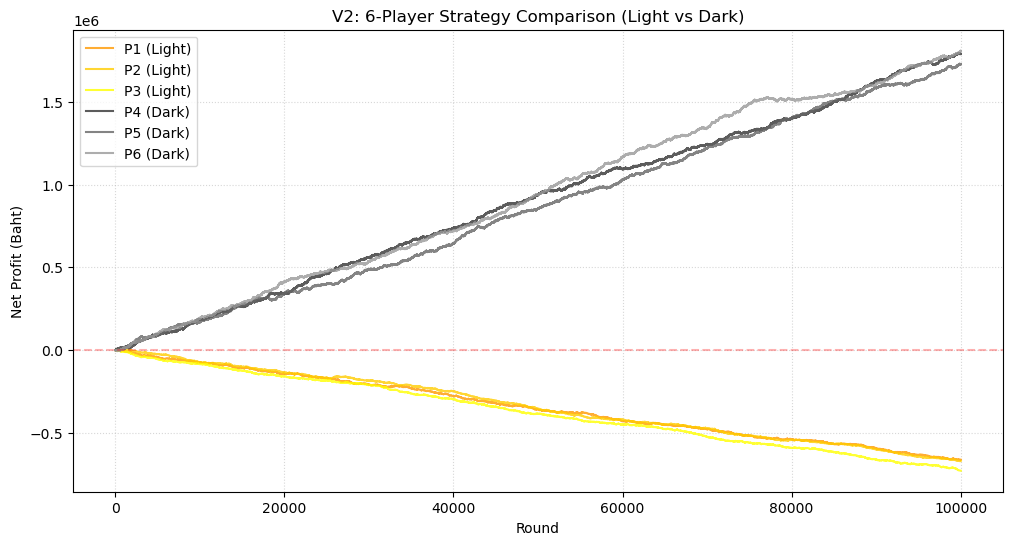

In [16]:
# --- Plotting ---
plt.figure(figsize=(12, 6))
colors = ['#FF9900', '#FFCC00', '#FFFF00', '#333333', '#666666', '#999999']
for i in range(NUM_PLAYERS):
    label = f"P{i+1} (Light)" if i < 3 else f"P{i+1} (Dark)"
    plt.plot(history_data[:, i], label=label, color=colors[i], alpha=0.8)

plt.title('V2: 6-Player Strategy Comparison (Light vs Dark)')
plt.xlabel('Round')
plt.ylabel('Net Profit (Baht)')
plt.axhline(0, color='red', linestyle='--', alpha=0.3)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# 🏁 Conclusion: Pai Tee Taek Strategy Analysis (Version 2)

This document summarizes the findings from the **Multiplayer Pot Simulation**, comparing the theoretical results of Version 1 with the realistic multiplayer dynamics of Version 2.

---

## 📊 1. Comparison: Theory vs. Reality

| Feature | Version 1 (Single Player) | Version 2 (6-Player Circle) |
| :--- | :--- | :--- |
| **Opponents** | None (Static Environment) | **5 Active Opponents** |
| **Central Pot** | Infinite / Not Simulated | **Limited (฿1,200)** |
| **Refill Mechanic** | None | **Pot Tax (฿200)** paid by everyone |
| **Primary Risk** | Losing the bet | **Paying for other players' wins** |
| **Reality Level** | Statistical Baseline | **Realistic Gambling Scenario** |

---

## 🔍 2. Key Insights & Findings

### 💸 The "Pot Tax" (Refill Burden)
The most critical discovery in Version 2 is the **Refill Mechanic**. 
* Whenever a "Dark" player wins (฿500), the pot often hits zero. 
* Even if a **Strategic Light** player is folding (not playing), they are forced to pay a **฿200 refill fee**.
* This acts as a constant "leak" or tax on patient players.

### 📈 Efficiency vs. Volume
* **Strategic Light (Selectivity):** Boasts a massive Win Rate (>60%) but plays very few hands (~7-8%). They are "Sniper" players who win big but rarely.
* **Pure Dark (Volume):** Has a lower Win Rate (~38%) but plays **100% of the hands**. They "drain" the pot constantly, forcing everyone else to pay for their volume.

---

## 🔢 3. Mathematical Edge: Expected Value ($EV$)

The **Pure Dark** strategy dominates because it exploits the **Asymmetric Risk** rule (Lose 50% / Win 100%):

$$EV_{\text{dark}} = (P_{\text{win}} \times 500) - (P_{\text{lose}} \times 250)$$

With a win rate of ~38%, the Dark player generates a positive $EV$ **every single round**. The Light player has a higher $EV$ *per game*, but their **Total $EV$ per Round** is often lower than the cumulative cost of the Pot Refills they have to pay while waiting for a good hand.ฃ

- From 100000 rounds of Monte-Carlo simulations, we get 0.38 * (+500) + 0.62 * (-250) = 35, which means the dark strategy has a positive expected value
**It means Dark Strategy is a better strategy when you play many rounds**


---

## 🏆 4. Final Verdict

In a realistic multiplayer setting with a shared pot:

1.  **The "Sponsor" Trap:** The **Strategic Light** player often becomes the "sponsor" of the table. By being too picky, they spend more money on **Pot Refills** for others than they earn from their own rare wins.
2.  **Volume is King:** The **Pure Dark** strategy is superior. By playing every hand and losing only half the bet, the high volume of play captures enough of the pot to more than cover the refill costs.
3.  **The Conclusion:** If the "Lose Half" rule exists and a shared pot refill is required, **Playing Dark (Blind)** is the mathematically optimal choice to maximize total net profit.

---
*Generated via Monte Carlo Simulation (100,000 Iterations)*

By Sirawitch Chairuangsirikul